# Comparing different lexicons

Let's see how sentiment analysis results will change when we change the lexicon we use for finding out emotional words.

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations
from sklearn.metrics import cohen_kappa_score
from statistics import mean

In [2]:
import warnings
warnings.simplefilter("ignore")

Also, some imports with Jupyter Notebook magic:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1 &emsp; Loading data

The script that generated the datasets is stored at [generate_lexicon_dataset.py](./generate_lexicon_dataset.py).

In [4]:
df = pd.read_csv("./data/lexicons_experiment.csv", sep=";", encoding="utf-8")
df.head()

,play,lexicon,"spoken, total",spoken positive,"spoken positive, %",spoken negative,"spoken negative, %","stage, total",stage positive,"stage positive, %",stage negative,"stage negative, %"
0,andreyev-ne-ubiy,RuSentiLex,971,155,15.962925,287,29.557158,340,37,10.882353,67,19.705882
1,andreyev-ne-ubiy,EmoLex,971,335,34.500515,144,14.830072,340,57,16.764706,54,15.882353
2,andreyev-ne-ubiy,LinisCrowd,971,140,14.418126,284,29.248198,340,36,10.588235,61,17.941176
3,andreyev-ne-ubiy,ChenSkiena,971,420,43.254377,131,13.491246,340,73,21.470588,49,14.411765
4,andreyev-ne-ubiy,ProductSentiRus,971,10,1.029866,684,70.442842,340,2,0.588235,221,65.000000


In [5]:
df_by_line = pd.read_csv("./data/lexicons_by_line.csv", sep=";", encoding="utf-8")
df_by_line.head()

,play,line,line type,RuSentiLex,EmoLex,LinisCrowd,ChenSkiena,ProductSentiRus
0,andreyev-ne-ubiy,что задумываться василиса петровна я приходить,spoken,0,0,0,0,-1
1,andreyev-ne-ubiy,да вот думать все,spoken,0,1,0,0,-1
2,andreyev-ne-ubiy,ну думать,spoken,0,0,0,1,-1
3,andreyev-ne-ubiy,холодно да вот думать все ты знать яков скольк...,spoken,0,1,0,-1,-1
4,andreyev-ne-ubiy,я частокольчик доламывать теперь день на два т...,spoken,-1,-1,0,0,-1


## 2 &emsp; Visualisation

Let's visualise amounts of found emotional lines by play for each lexicon:

### 2.1 &emsp; Spoken text

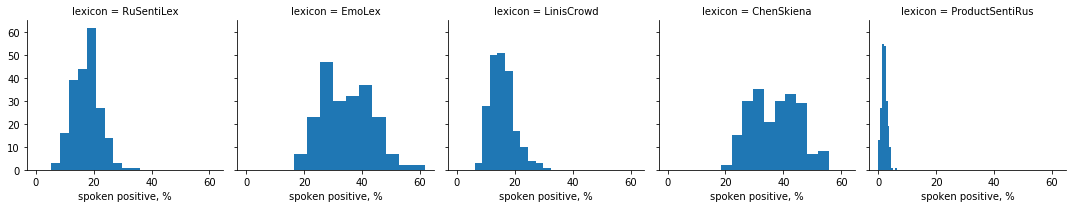

In [7]:
g = sns.FacetGrid(df, col="lexicon", palette=sns.cubehelix_palette(7, start=.8))
# plt.suptitle("Distribution of positive phrases in plays")
g.map(plt.hist, "spoken positive, %");
plt.savefig("./data/figures/spoken_positive_by_lexicon.png", dpi=600)

X-axis is a percentage of phrases in a play labeled positive, Y-axis is amount of plays with given percentage.

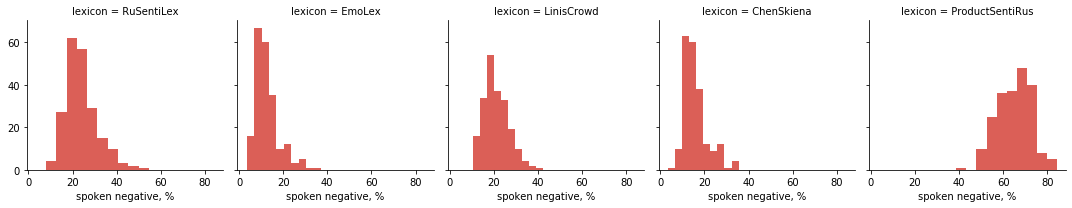

In [9]:
g = sns.FacetGrid(df, col="lexicon", palette=sns.color_palette("hls", 8))
g.map(plt.hist, "spoken negative, %");
plt.savefig("./data/figures/spoken_negative_by_lexicon.png", dpi=600)

### 2.2 &emsp; Stage directions

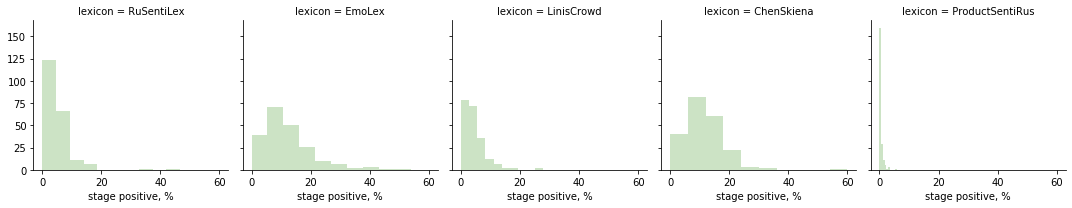

In [13]:
g = sns.FacetGrid(df, col="lexicon")
# plt.suptitle("Distribution of positive phrases in plays")
sns.set_palette(sns.cubehelix_palette(7, start=.8))
g.map(plt.hist, "stage positive, %");
plt.savefig("./data/figures/stage_positive_by_lexicon.png", dpi=600)

X-axis is a percentage of phrases in a play labeled positive, Y-axis is amount of plays with given percentage.

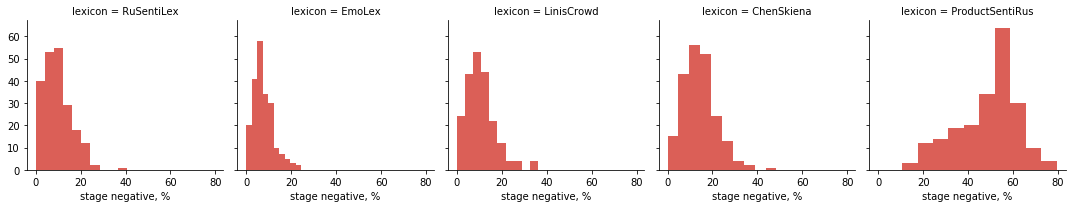

In [15]:
g = sns.FacetGrid(df, col="lexicon")
sns.set_palette(sns.color_palette("hls", 8))
g.map(plt.hist, "stage negative, %");
plt.savefig("./data/figures/stage_negative_by_lexicon.png", dpi=600)

### What can we get from these?

- stage directions are, in general, less emotional (as expected)

- results shown by EmoLex and Chen and Skiena's lexicons are quite the same, especially when looking at spoken text (this might be due to the fact that they are both Google Translate-based)

- ProductSentiRus shows way too much negative stage directions (needs a more proper check)

### 2.3. Inter-lexicon agreement

In [17]:
lexicons = ["RuSentiLex", "EmoLex", "LinisCrowd", "ChenSkiena", "ProductSentiRus"]
lexicons_pairs = []
for item in combinations(lexicons, 2):
    lexicons_pairs.append(item)
lexicons_pairwise = {pair: [] for pair in lexicons_pairs}

In [18]:
for play_name in df_by_line["play"].unique():
    print(play_name)
    try:
        kappas = []
        data_to_viz = df_by_line[df_by_line["play"] == play_name][lexicons]
        for pair in lexicons_pairs:
            k = cohen_kappa_score(data_to_viz[pair[0]], data_to_viz[pair[1]])
            kappas.append(k)
            lexicons_pairwise[pair].append(k)
            print("\t", pair, k)
        print("AVERAGE: {}".format(sum(kappas)/len(kappas)))
    except:
        print("ERROR")

andreyev-ne-ubiy
	 ('RuSentiLex', 'EmoLex') 0.31871109806224307
	 ('RuSentiLex', 'LinisCrowd') 0.5157864424711174
	 ('RuSentiLex', 'ChenSkiena') 0.3030985521438063
	 ('RuSentiLex', 'ProductSentiRus') 0.21074383562770138
	 ('EmoLex', 'LinisCrowd') 0.23296130077315436
	 ('EmoLex', 'ChenSkiena') 0.33929776554702884
	 ('EmoLex', 'ProductSentiRus') 0.16146513340363777
	 ('LinisCrowd', 'ChenSkiena') 0.2730559102598624
	 ('LinisCrowd', 'ProductSentiRus') 0.1832664912672305
	 ('ChenSkiena', 'ProductSentiRus') 0.1680889126421894
AVERAGE: 0.27064754421979714
andreyev-mysl
	 ('RuSentiLex', 'EmoLex') 0.29720698797806266
	 ('RuSentiLex', 'LinisCrowd') 0.444779957530537
	 ('RuSentiLex', 'ChenSkiena') 0.25503475316342905
	 ('RuSentiLex', 'ProductSentiRus') 0.18355954083946835
	 ('EmoLex', 'LinisCrowd') 0.24885162780190273
	 ('EmoLex', 'ChenSkiena') 0.3103828754275626
	 ('EmoLex', 'ProductSentiRus') 0.11787883762928919
	 ('LinisCrowd', 'ChenSkiena') 0.26524928387762703
	 ('LinisCrowd', 'ProductSentiRu

In [19]:
lexicons_pairwise_mean = {
    lexicons_key: mean(lexicons_pairwise[lexicons_key]) for lexicons_key in lexicons_pairwise
}

Converting these into a Seaborn heatmap to visualise agreement:

In [20]:
M = np.zeros((len(lexicons), len(lexicons)))
for l_mean in lexicons_pairwise_mean:
    ind_1 = lexicons.index(l_mean[0])
    ind_2 = lexicons.index(l_mean[1])
    M[ind_1][ind_2] = lexicons_pairwise_mean[l_mean]

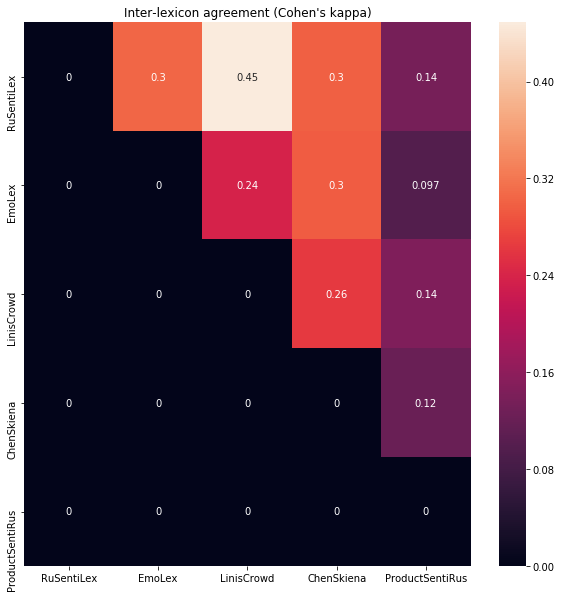

In [26]:
plt.figure(figsize=(10,10))
plt.title("Inter-lexicon agreement (Cohen's kappa)")
sns.heatmap(M, xticklabels=lexicons, yticklabels=lexicons, annot=True);
plt.savefig("./data/figures/inter_lexicon_agreement.png", dpi=600)